In [1]:
import notebook_import
import arrhythmia.experimental.mitdb as mitdb
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

Using TensorFlow backend.


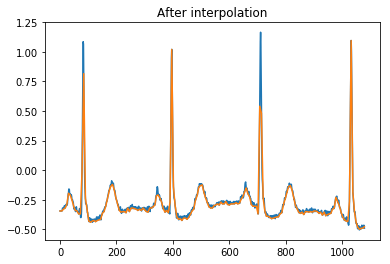

Unique label sets and their count:
[0. 0. 0.] 703
[0. 1. 0.] 565
[0. 1. 1.] 114
[1. 0. 0.] 312
[1. 0. 1.] 2
[1. 1. 0.] 228
[1. 1. 1.] 144
Total of 2068 samples


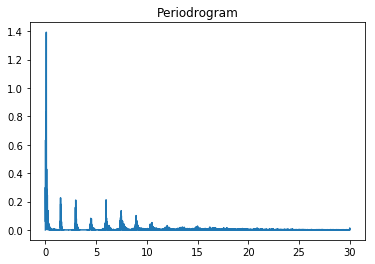

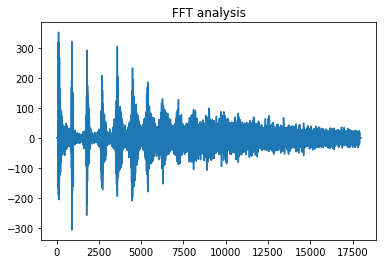

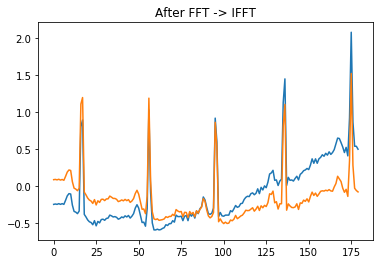

In [2]:
# Load all mitdb records
full_data = mitdb.get_records(mitdb.full_ds)

# Slice all data into time frames of size 10 min + 5 min
from arrhythmia.experimental.common import slice_records
from arrhythmia.model.helpers import beat_types
from arrhythmia.model.time_series import linear_interpolation

pred_minutes = 5
post_minutes = 2

pred_window = 360 * 60 * pred_minutes
post_window = 360 * 60 * post_minutes

slicer = slice_records(full_data, pred_window, post_window, increment=360 * 30, check_pred=False)

# Convert loaded data into model input and expected classes
def to_classes(labels, threshold=1):
    targets = np.zeros(len(beat_types[1:-1]), dtype=np.float32)
    for i, bt in enumerate(beat_types[1:-1]):
        count = np.sum(labels == bt.symbol)
        targets[i] = 1.0 if count >= threshold else 0.0
    return targets

# Downsample data to reduce number of features and remove high f. noise at the same time
frequency = 360
target_frequency = 60
input_data = []
classes = []
for i, (pred, post) in enumerate(slicer):
    data = pred[0]
    cl = to_classes(post[2])
    if target_frequency != frequency:
        if i == 0:
            plt.plot(data[:frequency*3])
        data = linear_interpolation(data, target_frequency * 60 * pred_minutes)
        if i == 0:
            back_int = linear_interpolation(data, pred_window)
            plt.plot(back_int[:frequency*3])
            plt.title('After interpolation')
            plt.show()

    input_data.append(data)
    classes.append(cl)

frequency = target_frequency
        
input_data = np.array(input_data)
classes = np.array(classes)
        
unique, cnts = np.unique(classes, axis=0, return_counts=True)
print('Unique label sets and their count:')
for u, c in zip(unique, cnts):
    print(u, c)
print('Total of {} samples'.format(sum(cnts)))

# Plot periodogram
periodogram = True
if periodogram:
    from scipy.signal import periodogram
    f, pxx = periodogram(input_data[-2], frequency, return_onesided=True)
    plt.plot(f, pxx)
    plt.title('Periodrogram')
    plt.show()

# Remove low frequency noise using FFT->IFFT
fft = True
replace_with_fft = False
fft_threshold = 0.3
if fft:
    from scipy import fftpack
    after_fft = fftpack.rfft(input_data)

    fft_freq = fftpack.fftfreq(after_fft.shape[-1], d=1/frequency)

    after_fft[:, np.abs(fft_freq) < fft_threshold] = 0
    plt.plot(after_fft[-2].real)
    plt.title('FFT analysis')
    plt.show()
    
    if not replace_with_fft:
        plt.plot(input_data[-2][:frequency*3])
        input_data = fftpack.irfft(after_fft)
        plt.plot(input_data[-2][:frequency*3])
        plt.title('After FFT -> IFFT')
        plt.show()
    else:
        input_data = fft_freq.real

input_data = np.array(input_data)
input_shape = input_data.shape[1:]

# Normalize input data
from arrhythmia.experimental.common import normalize_mean_std

input_data_n = normalize_mean_std(input_data)

In [3]:
from arrhythmia.experimental.common import ModelTester
import keras.backend as K
# TODO Update keras to use those metrics
#from keras.metrics import precision, recall

tester = ModelTester(input_data_n, classes, verbose=0)

def precision(y_true, y_pred):
    '''Calculates the precision, a metric for multi-label classification of
    how many selected items are relevant.
    '''
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    '''Calculates the recall, a metric for multi-label classification of
    how many relevant items are selected.
    '''
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def fbeta_score(y_true, y_pred, beta=1):
    '''Calculates the F score, the weighted harmonic mean of precision and recall.
    This is useful for multi-label classification, where input samples can be
    classified as sets of labels. By only using accuracy (precision) a model
    would achieve a perfect score by simply assigning every class to every
    input. In order to avoid this, a metric should penalize incorrect class
    assignments as well (recall). The F-beta score (ranged from 0.0 to 1.0)
    computes this, as a weighted mean of the proportion of correct class
    assignments vs. the proportion of incorrect class assignments.
    With beta = 1, this is equivalent to a F-measure. With beta < 1, assigning
    correct classes becomes more important, and with beta > 1 the metric is
    instead weighted towards penalizing incorrect class assignments.
    '''
    if beta < 0:
        raise ValueError('The lowest choosable beta is zero (only precision).')
        
    # If there are no true positives, fix the F score at 0 like sklearn.
    if K.sum(K.round(K.clip(y_true, 0, 1))) == 0:
        return 0

    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    bb = beta ** 2
    fbeta_score = (1 + bb) * (p * r) / (bb * p + r + K.epsilon())
    return fbeta_score


def fmeasure(y_true, y_pred):
    '''Calculates the f-measure, the harmonic mean of precision and recall.
    '''
    return fbeta_score(y_true, y_pred, beta=1)

metrics = ['binary_accuracy', 'mse', precision, recall, fmeasure]

window_postfix = str(pred_minutes) + '_' + str(post_minutes)
def network_name(name):
    return 'mlp_' + str(name) + '_window' + window_postfix + '.hdf5'

## Networks:
from keras.models import Model
from keras.layers import Input, Dense, Reshape, Conv1D, MaxPooling1D, Flatten


def simple_network(layers=None):
    def builder():
        inputs = Input(shape=input_shape)
        x = inputs
        for layer in layers:
            x = Dense(layer, activation='relu')(x)
        outputs = Dense(len(beat_types) - 2, activation='sigmoid')(x)
        model = Model(inputs=inputs, outputs=outputs)
        model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=metrics)
        return model
    return builder

def conv_network(pool=4, layers=None):
    def builder():
        inputs = Input(shape=input_shape)
        x = Reshape((*input_shape, 1))(inputs)
        for size, num in layers:
            x = Conv1D(size, num, activation='relu')(x)
            x = MaxPooling1D(pool_size=pool)(x)
        x = Flatten()(x)
        outputs = Dense(len(beat_types) - 2, activation='sigmoid')(x)
        model = Model(inputs=inputs, outputs=outputs)
        model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=metrics)
        return model
    return builder

Testing simple model with layers: [10, 50, 10]
Trained for 11 epochs
loss: 0.6139, binary_accuracy: 0.6578, mean_squared_error: 0.2112, precision: 0.4974, recall: 0.3939, fmeasure: 0.4058
Trained for 8 epochs
loss: 0.6069, binary_accuracy: 0.6675, mean_squared_error: 0.2065, precision: 0.5072, recall: 0.2488, fmeasure: 0.3217
Trained for 11 epochs
loss: 0.5757, binary_accuracy: 0.7013, mean_squared_error: 0.1940, precision: 0.5373, recall: 0.3069, fmeasure: 0.3731
Trained for 15 epochs
loss: 0.5821, binary_accuracy: 0.6909, mean_squared_error: 0.1980, precision: 0.5171, recall: 0.2639, fmeasure: 0.3424
Trained for 10 epochs
loss: 0.5719, binary_accuracy: 0.6965, mean_squared_error: 0.1941, precision: 0.4409, recall: 0.2166, fmeasure: 0.2852
loss: 0.5901 (+/-0.0170), binary_accuracy: 0.6828 (+/-0.0171), mean_squared_error: 0.2008 (+/-0.0069), precision: 0.5000 (+/-0.0323), recall: 0.2860 (+/-0.0613), fmeasure: 0.3456 (+/-0.0415)


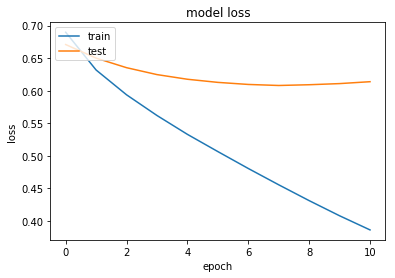

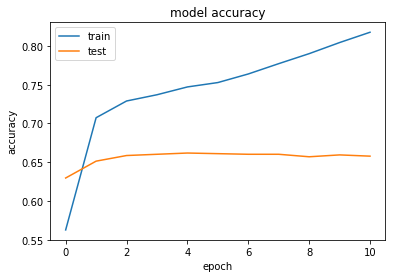

Testing simple model with layers: [100, 100]
Trained for 6 epochs
loss: 0.6131, binary_accuracy: 0.6812, mean_squared_error: 0.2083, precision: 0.4817, recall: 0.3304, fmeasure: 0.3770
Trained for 6 epochs
loss: 0.5985, binary_accuracy: 0.6836, mean_squared_error: 0.2023, precision: 0.5024, recall: 0.3269, fmeasure: 0.3731
Trained for 6 epochs
loss: 0.6145, binary_accuracy: 0.6892, mean_squared_error: 0.2064, precision: 0.4686, recall: 0.3531, fmeasure: 0.3815
Trained for 8 epochs
loss: 0.5850, binary_accuracy: 0.6965, mean_squared_error: 0.1987, precision: 0.4989, recall: 0.3778, fmeasure: 0.4171
Trained for 6 epochs
loss: 0.5721, binary_accuracy: 0.7103, mean_squared_error: 0.1931, precision: 0.4698, recall: 0.3784, fmeasure: 0.4053
loss: 0.5966 (+/-0.0163), binary_accuracy: 0.6921 (+/-0.0105), mean_squared_error: 0.2017 (+/-0.0055), precision: 0.4843 (+/-0.0142), recall: 0.3533 (+/-0.0221), fmeasure: 0.3908 (+/-0.0173)


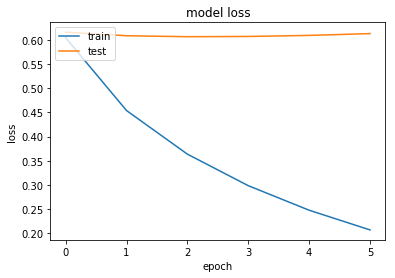

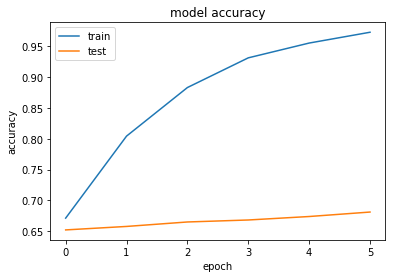

Testing simple model with layers: [100, 200, 100]
Trained for 6 epochs
loss: 0.6069, binary_accuracy: 0.6723, mean_squared_error: 0.2065, precision: 0.5219, recall: 0.3055, fmeasure: 0.3689
Trained for 6 epochs
loss: 0.5965, binary_accuracy: 0.6731, mean_squared_error: 0.2037, precision: 0.4939, recall: 0.3073, fmeasure: 0.3614
Trained for 7 epochs
loss: 0.5863, binary_accuracy: 0.6763, mean_squared_error: 0.1983, precision: 0.4691, recall: 0.3394, fmeasure: 0.3767
Trained for 7 epochs
loss: 0.5818, binary_accuracy: 0.6860, mean_squared_error: 0.1981, precision: 0.4968, recall: 0.3079, fmeasure: 0.3631
Trained for 8 epochs
loss: 0.5587, binary_accuracy: 0.7103, mean_squared_error: 0.1891, precision: 0.4801, recall: 0.4238, fmeasure: 0.4377
loss: 0.5860 (+/-0.0162), binary_accuracy: 0.6836 (+/-0.0142), mean_squared_error: 0.1991 (+/-0.0060), precision: 0.4924 (+/-0.0178), recall: 0.3368 (+/-0.0453), fmeasure: 0.3815 (+/-0.0286)


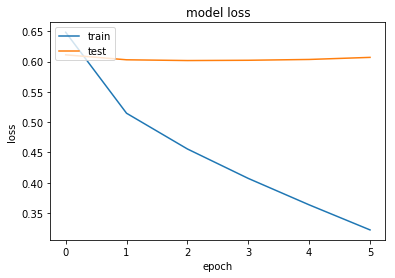

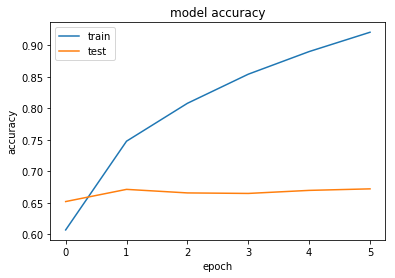

In [4]:
import itertools

considered_widths = [
    [10, 50, 10],
    [100, 100],
    [100, 200, 100]
]

for widths in considered_widths:
    print('Testing simple model with layers: {}'.format(widths))
    filename = network_name('dense_' + '_'.join([str(w) for w in widths]))
    simple_trained = tester.test_model(simple_network(widths), max_epochs=50)
    # Dense networks have very poor results and easly overfit - we disable saving them
    #simple_trained.save(filename)

Test convolutional network with parameters {'pool': 16, 'layers': [(4, 16), (16, 16)]}:
Trained for 32 epochs
loss: 0.3688, binary_accuracy: 0.8559, mean_squared_error: 0.1108, precision: 0.9320, recall: 0.5798, fmeasure: 0.7034
Trained for 12 epochs
loss: 0.4476, binary_accuracy: 0.7963, mean_squared_error: 0.1440, precision: 0.9741, recall: 0.3734, fmeasure: 0.5240
Trained for 23 epochs
loss: 0.3676, binary_accuracy: 0.8486, mean_squared_error: 0.1154, precision: 0.7766, recall: 0.6717, fmeasure: 0.7105
Trained for 25 epochs
loss: 0.4284, binary_accuracy: 0.8184, mean_squared_error: 0.1315, precision: 0.9367, recall: 0.4617, fmeasure: 0.5955
Trained for 18 epochs
loss: 0.3602, binary_accuracy: 0.8458, mean_squared_error: 0.1132, precision: 0.7555, recall: 0.5887, fmeasure: 0.6488
loss: 0.3945 (+/-0.0361), binary_accuracy: 0.8330 (+/-0.0223), mean_squared_error: 0.1230 (+/-0.0128), precision: 0.8750 (+/-0.0904), recall: 0.5351 (+/-0.1049), fmeasure: 0.6365 (+/-0.0699)


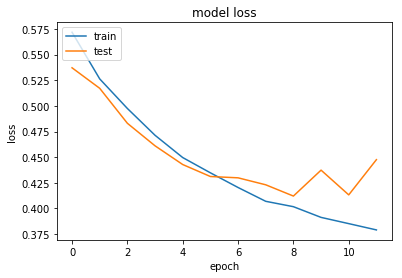

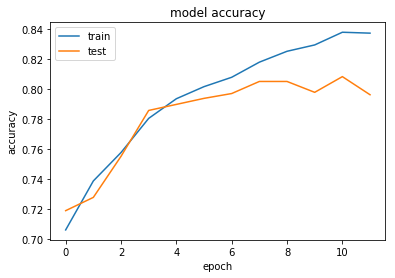

Test convolutional network with parameters {'pool': 16, 'layers': [(32, 16), (16, 16)]}:
Trained for 20 epochs
loss: 0.3363, binary_accuracy: 0.8615, mean_squared_error: 0.1035, precision: 0.9332, recall: 0.6037, fmeasure: 0.7224
Trained for 22 epochs
loss: 0.3421, binary_accuracy: 0.8599, mean_squared_error: 0.1055, precision: 0.9285, recall: 0.5847, fmeasure: 0.6941
Trained for 19 epochs
loss: 0.3483, binary_accuracy: 0.8422, mean_squared_error: 0.1099, precision: 0.9142, recall: 0.5258, fmeasure: 0.6439
Trained for 18 epochs
loss: 0.3339, binary_accuracy: 0.8644, mean_squared_error: 0.1016, precision: 0.9217, recall: 0.6194, fmeasure: 0.7245
Trained for 13 epochs
loss: 0.3754, binary_accuracy: 0.8434, mean_squared_error: 0.1179, precision: 0.6970, recall: 0.6940, fmeasure: 0.6818
loss: 0.3472 (+/-0.0150), binary_accuracy: 0.8543 (+/-0.0095), mean_squared_error: 0.1077 (+/-0.0058), precision: 0.8789 (+/-0.0912), recall: 0.6055 (+/-0.0544), fmeasure: 0.6934 (+/-0.0296)


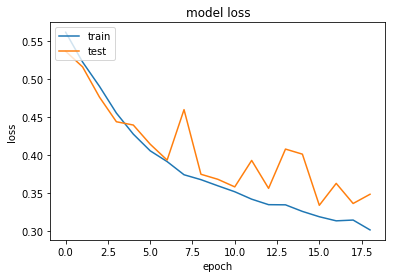

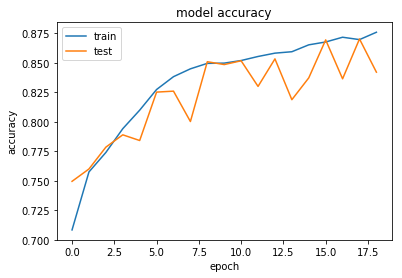

Test convolutional network with parameters {'pool': 8, 'layers': [(16, 16), (8, 16), (4, 16)]}:
Trained for 24 epochs
loss: 0.4020, binary_accuracy: 0.8180, mean_squared_error: 0.1276, precision: 0.9473, recall: 0.4266, fmeasure: 0.5701
Trained for 20 epochs
loss: 0.4049, binary_accuracy: 0.8100, mean_squared_error: 0.1318, precision: 0.8930, recall: 0.4241, fmeasure: 0.5608
Trained for 20 epochs
loss: 0.4334, binary_accuracy: 0.7963, mean_squared_error: 0.1415, precision: 0.7990, recall: 0.3628, fmeasure: 0.4752
Trained for 14 epochs
loss: 0.4156, binary_accuracy: 0.8232, mean_squared_error: 0.1333, precision: 0.7765, recall: 0.5563, fmeasure: 0.6395
Trained for 19 epochs
loss: 0.3812, binary_accuracy: 0.8273, mean_squared_error: 0.1221, precision: 0.6352, recall: 0.7575, fmeasure: 0.6804
loss: 0.4074 (+/-0.0171), binary_accuracy: 0.8150 (+/-0.0110), mean_squared_error: 0.1313 (+/-0.0064), precision: 0.8102 (+/-0.1073), recall: 0.5055 (+/-0.1409), fmeasure: 0.5852 (+/-0.0706)


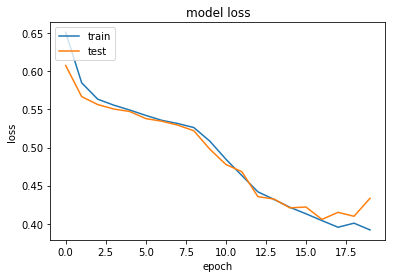

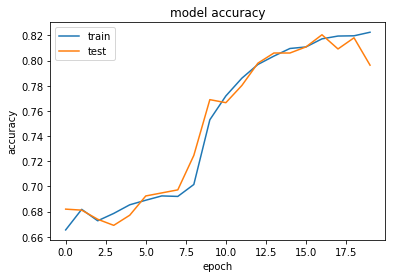

In [5]:
considered_variants = [
    {'pool': 16, 'layers': [(4, 16), (16, 16)]},
    {'pool': 16, 'layers': [(32, 16), (16, 16)]},
    {'pool': 8, 'layers': [(16, 16), (8, 16), (4, 16)]},
]

for i, variant in enumerate(considered_variants):
    print("Test convolutional network with parameters {}:".format(variant))
    filename = network_name('conv_' + str(i))
    trained = tester.test_model(conv_network(**variant), max_epochs=50)
    trained.save(filename)